##  Filling gaps and Jump detection in GWL observation


The gap filling process for the groundwater level records is thought for preparing the input data for the machine learning models. To guarantee the robustness of these datasets, a first filter should be applied to remove gaps greater than 3 months (if the data is in monthly resolution), meaning two missing values. Following this, the proportion of filled values should remain low to keep a reliable dataset. 
To fill the gaps, the wells located until a certain distance of the target well (the one to be filled) are selected and constrained to the same time-range. From this selection of wells, the ones with more than 2% missing data are removed and the remaining ones are filled with the time series mean. Then, the similarity between the target wells and the surrounding ones is checked by computing the eculidean distance, this allows to take only similar time series. 

If, after the previous procedure, there are still available wells to fill the missing gaps in the target one, a multiple linear regression (MLR) is computed. When there are no wells to perform MLR or if the score (accuracy) is not sufficient, the gaps are filled with PCHIP (Piecewise Cubic Hermite Interpolating Polynomial).

The procedure is in developed in the functions library- class fillGWgaps

In [1]:
#Import libraries
from functions import fillGWgaps
import pandas as pd
import geopandas as gpd
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler
import datetime
%matplotlib notebook
warnings.filterwarnings('ignore')

In [2]:
#Load groundwater data as a dataframe with the well ids and the time series information
rpath="D:/Data/students/mariana/data/" #Root path
gwdata=pd.read_pickle(rpath+"/Pickle/gwdata.pkl")
#Load groundwater observations filtered by gap length 
gwsel=pd.read_pickle(rpath+"/Pickle/gwsel.pkl") 

#load shapefile of stations
gws=gpd.read_file(rpath+"SHP/GWL_CDID.shp")

In [3]:
gwt=gwsel.copy()

In [4]:
gwt.sort_values(by="max_gap")

wellid                                               data  count  \
342   40505061        MEST_ID  JAHR  MONAT      DATUM  HJAHR  ...      0   
332   40504720        MEST_ID  JAHR  MONAT      DATUM  HJAHR  ...      0   
331   40504710        MEST_ID  JAHR  MONAT      DATUM  HJAHR  ...      0   
330   40504671        MEST_ID  JAHR  MONAT      DATUM  HJAHR  ...      0   
329   40504591        MEST_ID  JAHR  MONAT      DATUM  HJAHR  ...      0   
..         ...                                                ...    ...   
471  400060391         MEST_ID  JAHR  MONAT      DATUM  HJAHR ...      3   
513  405030392         MEST_ID  JAHR  MONAT      DATUM  HJAHR ...      3   
99   400080190         MEST_ID  JAHR  MONAT      DATUM  HJAHR ...      6   
249    9700285       MEST_ID  JAHR  MONAT      DATUM  HJAHR  H...      1   
634  400050162         MEST_ID  JAHR  MONAT      DATUM  HJAHR ...      2   

                                                  gaps  max_gap  \
342    Series([], Name: DATUM, dtype: timedelta64[ns])      0.0   
332    Series([], Name: DATUM, dtype: timedelta64[ns])      0.0   
331    Series([], Name: DATUM, dtype: timedelta64[ns])      0.0   
330    Series([], Name: DATUM, dtype: timedelta64[ns])      0.0   
329    Series([], Name: DATUM, dtype: timedelta64[ns])      0.0   
..                                                 ...      ...   
471  349   62 days
848   62 days
856   89 days
Name...     89.0   
513  349   62 days
848   62 days
856   89 days
Name...     89.0   
99   306   61 days
308   62 days
314   60 days
349 ...     89.0   
249  808   89 days
Name: DATUM, dtype: timedelta64[ns]     89.0   
634  848   62 days
856   89 days
Name: DATUM, dtype...     89.0   

     max_gap_months  
342        0.000000  
332        0.000000  
331        0.000000  
330        0.000000  
329        0.000000  
..              ...  
471        2.966667  
513        2.966667  
99         2.966667  
249        2.966667  
634        2.966667  

[505 rows x 6 columns]

In [5]:
#List of well id's to be filled
lwellid=gwt.wellid.values

### Fill data

The gaps are filled per well ID and saved into a Dataframe to later processing.

In [6]:
#Input the raw data here , this calls the functions.py library
dwfill=fillGWgaps(gwdata,gws, maxd=20*10e3,th=98, maxn=8) 

In [7]:
#filled the gaps per well id-- take hours to complete the 505 wells 
lgwfill,vtype,vratio, vnnan=[],[],[],[]
for w in lwellid:
    dftwell =dwfill.MLRmodel(twell=w)
    lgwfill.append(dftwell[0])
    vtype.append(dftwell[1])
    vratio.append(dftwell[2])
    vnnan.append(dftwell[3])


KeyboardInterrupt: 

In [55]:
#Total number of wells 
len(lgwfill)

505

In [41]:
#Check number of complete series and filled series with MLR and PCHIP method
values, counts = np.unique(vtype, return_counts=True)
print(values)
print(counts)

['MLR' 'PCHIP' 'complete']
[252  12 241]


In [54]:
#Check ratio (number of missing values / number of values) of filled values
vratio=np.round(np.array(vratio),1)
values, counts = np.unique(np.sort(vratio), return_counts=True)
print(values)
print(counts)

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  2.1  4.4 10.2]
[241  17  56  28  56  27  19  13  17   5   5   2   7   2   3   1   2   1
   1   1   1]


In [15]:
#Save data to a Dataframe 
#GWfilldat= pd.DataFrame({"wellid":lwellid, "GW_NN":lgwfill, "filledtype":vtype , "fillratio":vratio, "fillnum":vnnan})
#GWfilldat.to_pickle(rpath+"/Pickle/GWfilldata.pkl")

# Some plots

Visual check of the interpolation and gap filling method

<IPython.core.display.Javascript object>


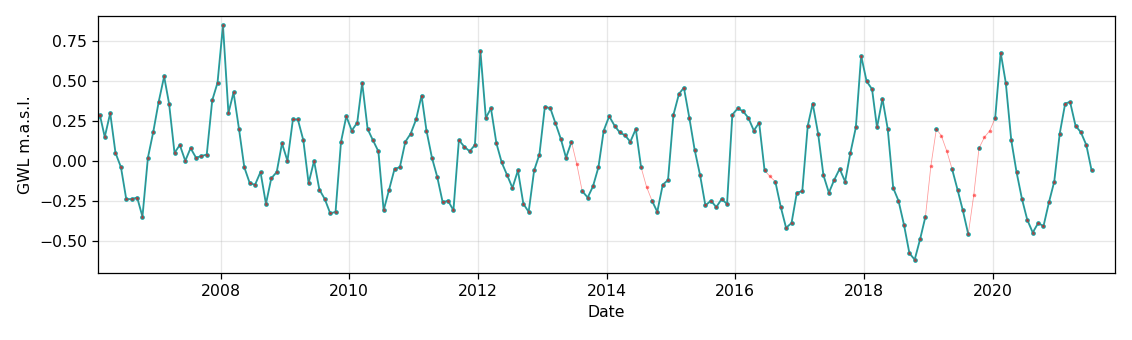

In [194]:
#When the well can't be filled with MLR then a PCHIP
dfax=gwt.loc[gwt.wellid==lwellid[0]].data[1].GW_NN
dates=gwt.loc[gwt.wellid==lwellid[0]].data[1].DATUM
iind=dfax.first_valid_index()
find=dfax.last_valid_index()
data=dfax.iloc[iind:find]

plt.figure(figsize=(10,3))
plt.plot(dates[iind:find],data, marker=".",markersize="4", linewidth="1.2", color="c")
plt.plot(dates[iind:find], data.interpolate(method="pchip", order=2), marker="*",
             markersize="2",linewidth="0.5", color="r", alpha=0.4)
#plt.plot(data.interpolate(method="polynomial", order=2), ls="-", lw=.5, color="green", alpha=0.5)
plt.ylabel("GWL m.a.s.l.")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [157]:
i=40
datafillw=lgwfill[i]
ind=gwt.loc[gwt.wellid==lwellid[i+3]].data.index.values[0]
datawell=gwt.loc[gwt.wellid==lwellid[i+3]].data[ind]
col=datafillw.columns[-1]

<IPython.core.display.Javascript object>


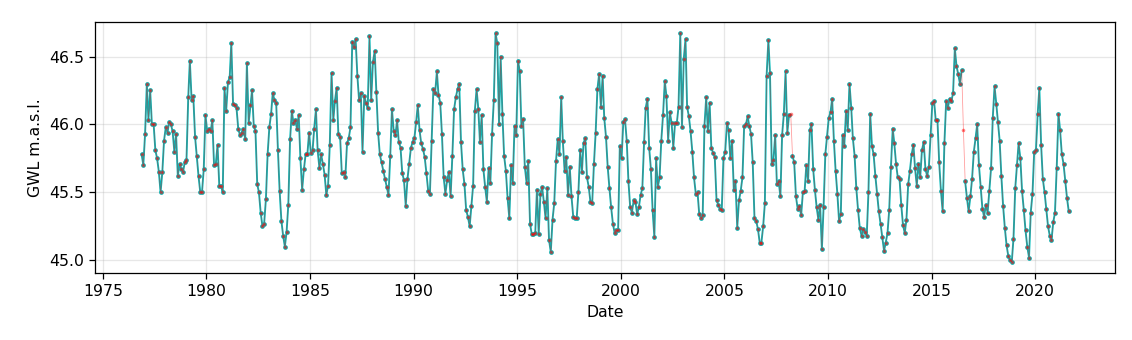

In [164]:
##PLOT TIME SERIES 
plt.figure(figsize=(10,3))
plt.plot(datawell["DATUM"],datawell["GW_NN"],marker=".",markersize="4", linewidth="1.2", color="c")
plt.plot(datafillw["DATUM"], datafillw[col], marker="*",
             markersize="2",linewidth="0.5", color="r", alpha=0.4)
plt.ylabel("GWL m.a.s.l.")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Check data quality before 1990

In [4]:
GWfilldata=pd.read_pickle(rpath+"/Pickle/GWfilldata.pkl")

In [5]:
## read only the wells with records before 1990
vgwell=[]
for gwell in GWfilldata.GW_NN:
    gw_well=gwell[[gwell.columns[0],gwell.columns[-1]]]
    if gw_well[gwell.columns[0]][0].year<=1990:
        vgwell.append(gw_well)


<IPython.core.display.Javascript object>


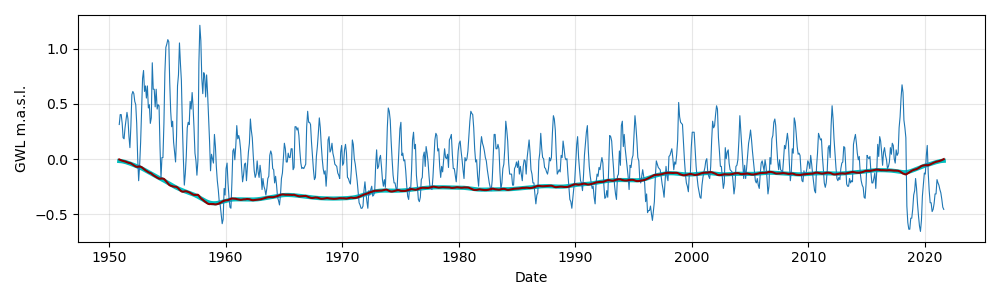

0.41086470588235274
yes
[0.42527896]


<IPython.core.display.Javascript object>


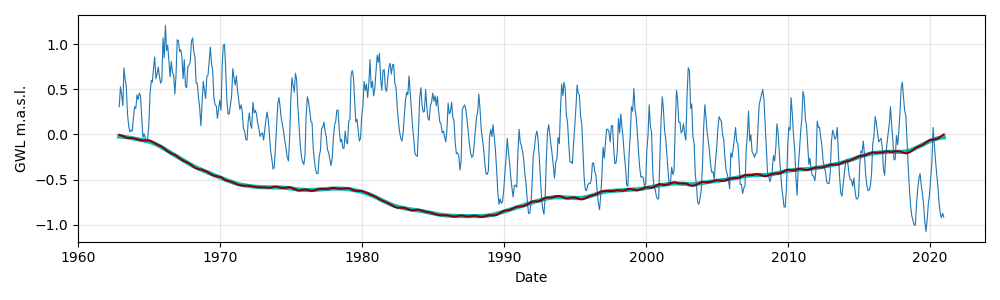

0.9116548710601816
yes
[0.29132473]


<IPython.core.display.Javascript object>


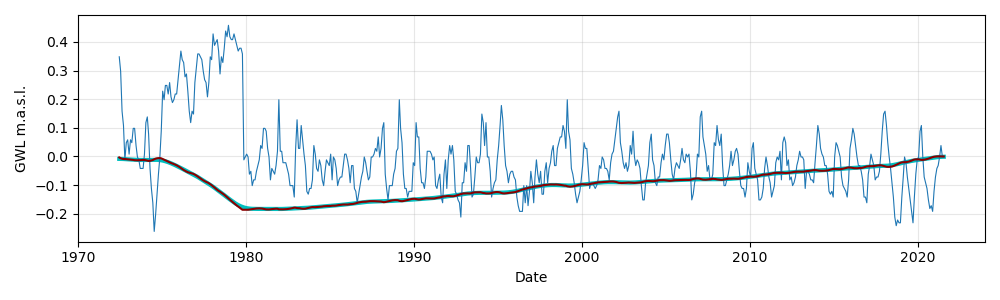

0.1862803389830508
yes
[0.33168178]


<IPython.core.display.Javascript object>


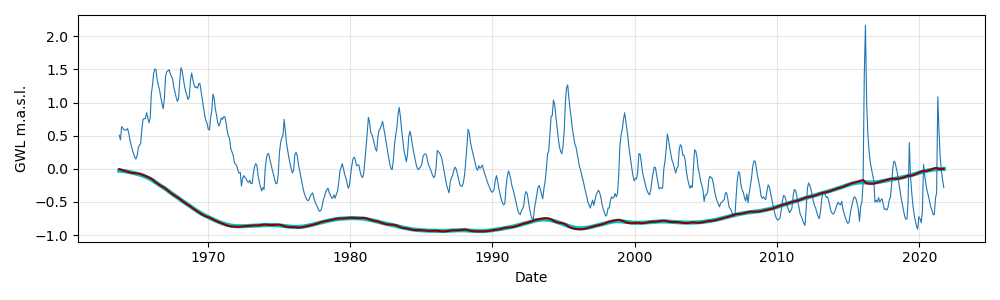

0.9455411500129888
yes
[0.32637683]


<IPython.core.display.Javascript object>


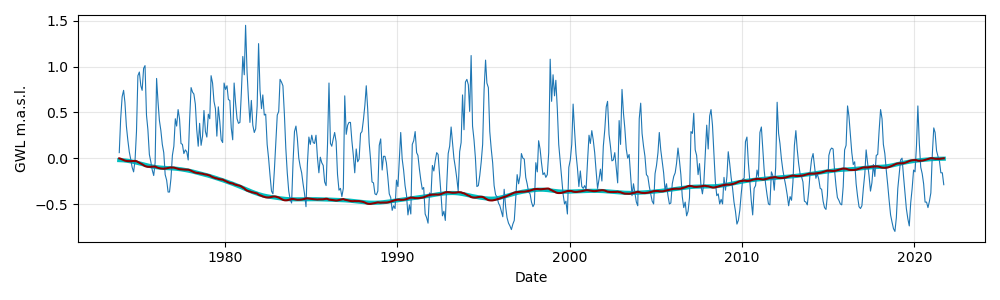

0.49779565217391325
yes
[0.27158624]


<IPython.core.display.Javascript object>


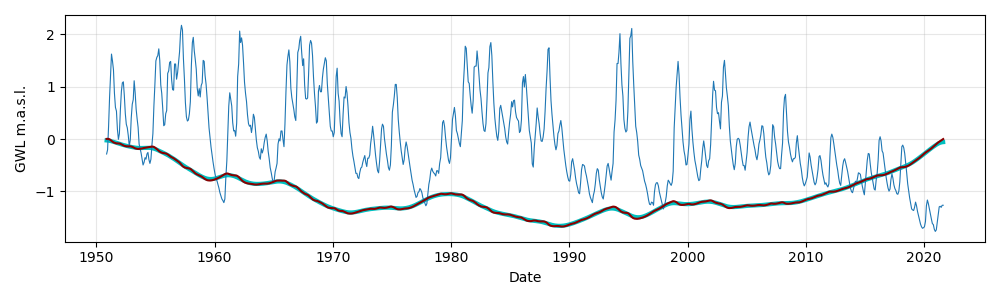

1.6720248235294193
yes
[0.35737724]


<IPython.core.display.Javascript object>


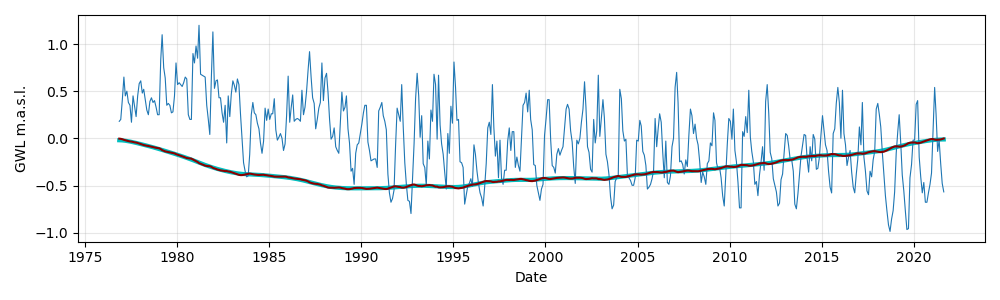

0.5388046950835527
yes
[0.35285344]


<IPython.core.display.Javascript object>


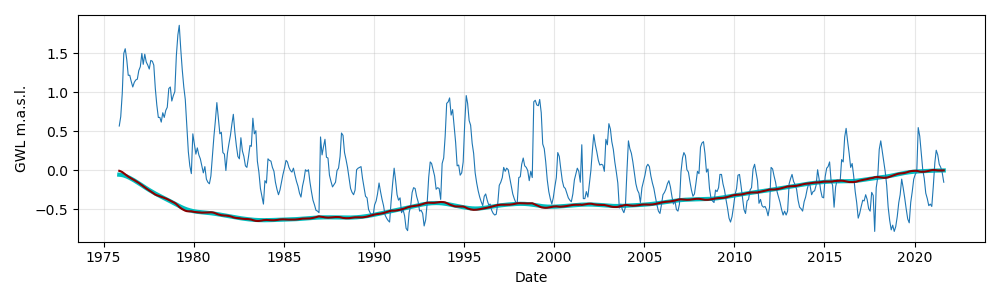

0.6480947078254227
yes
[0.655282]


<IPython.core.display.Javascript object>


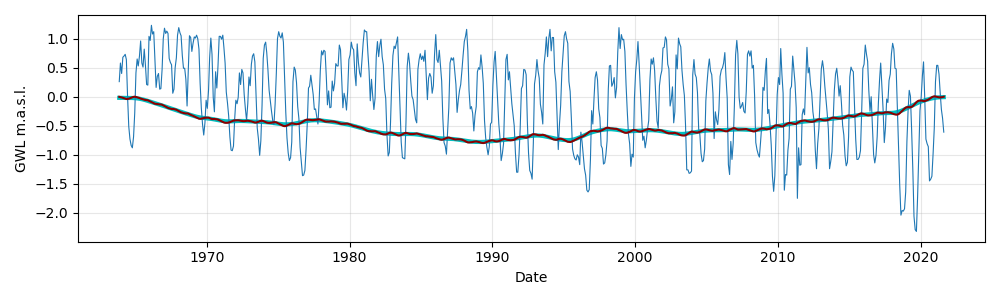

0.7991206221343387
yes
[0.25128227]


<IPython.core.display.Javascript object>


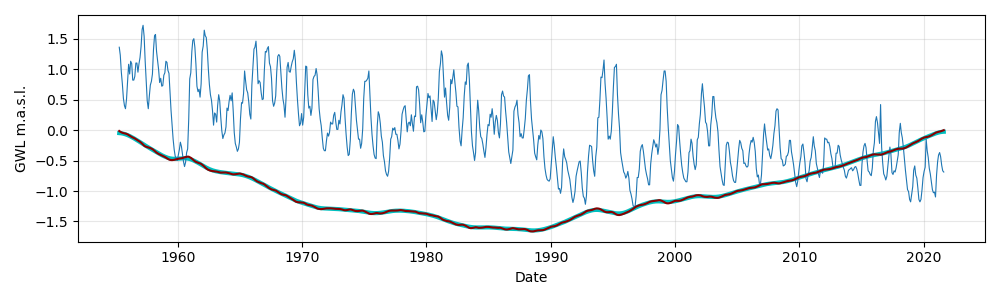

1.6633433901691377
yes
[0.38174935]


<IPython.core.display.Javascript object>


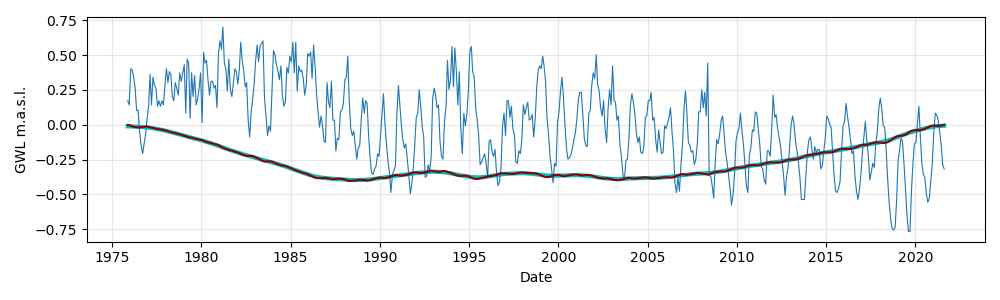

0.4036825048435601
yes
[0.2948311]


<IPython.core.display.Javascript object>


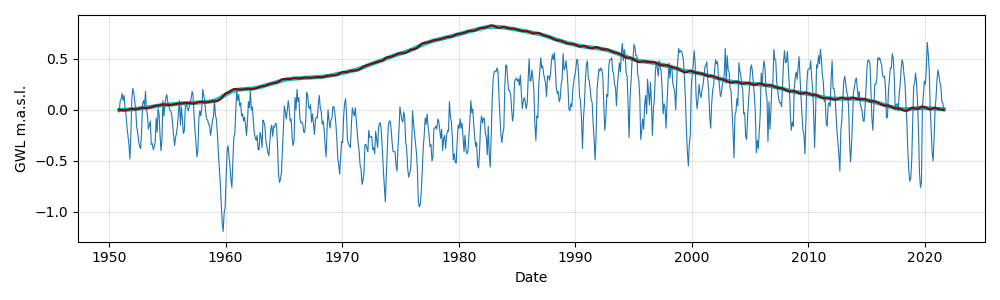

0.8265781176470172
yes
[0.25369038]


<IPython.core.display.Javascript object>


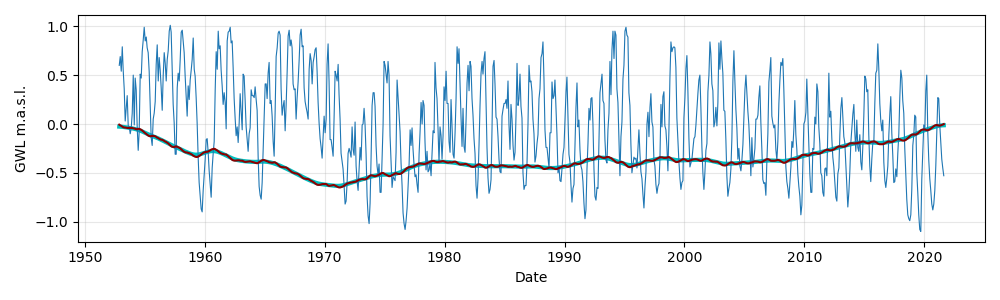

0.6492190570172958
yes
[0.29426032]


<IPython.core.display.Javascript object>


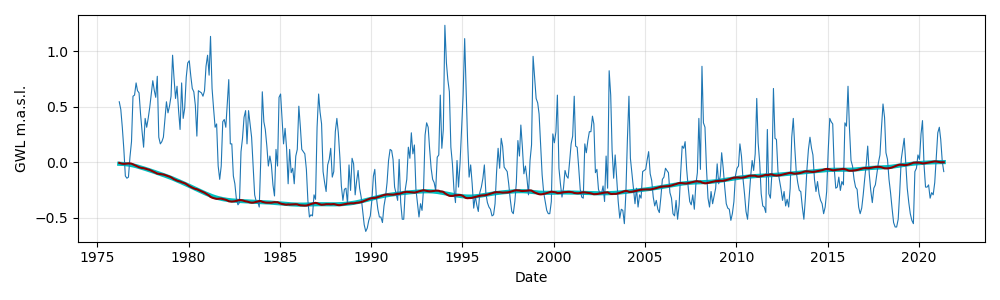

0.3912353591160218
yes
[0.32018596]


<IPython.core.display.Javascript object>


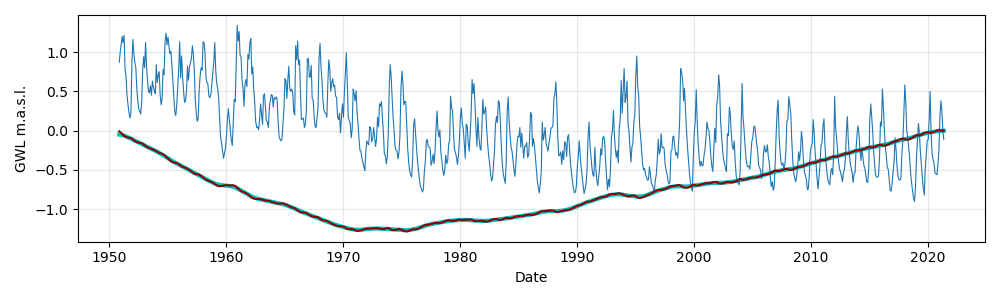

1.2817118063754436
yes
[0.40849252]


<IPython.core.display.Javascript object>


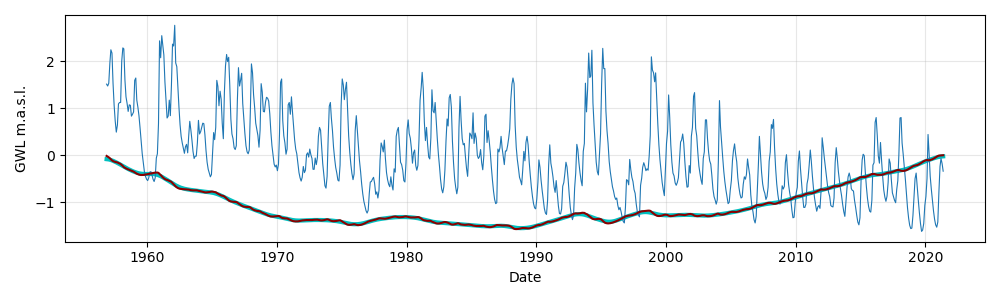

1.5699245161290534
yes
[0.3724531]


<IPython.core.display.Javascript object>


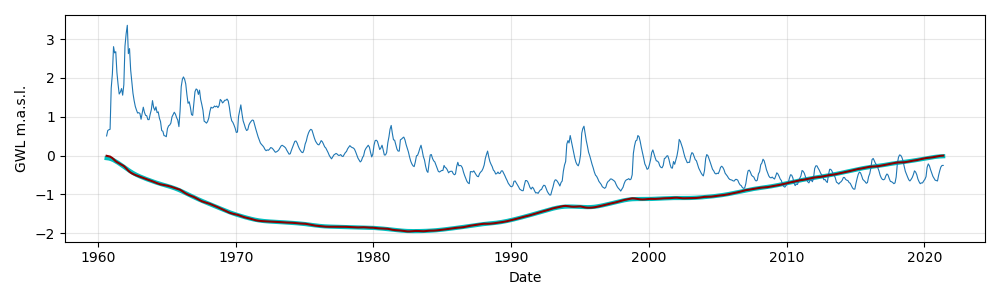

1.9527438356164344
yes
[0.67311051]


<IPython.core.display.Javascript object>


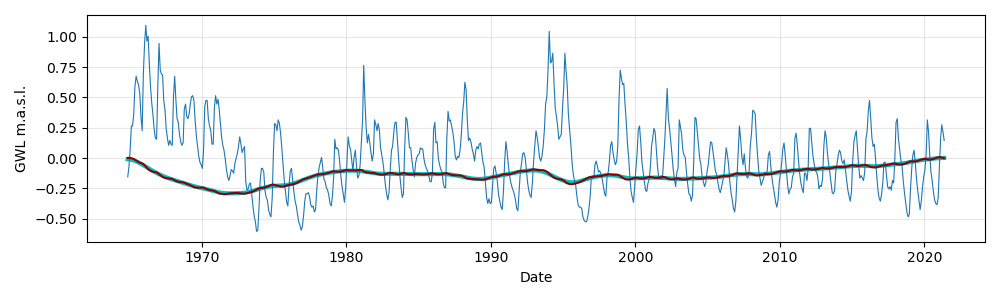

0.296666126656848
yes
[0.37250274]


<IPython.core.display.Javascript object>


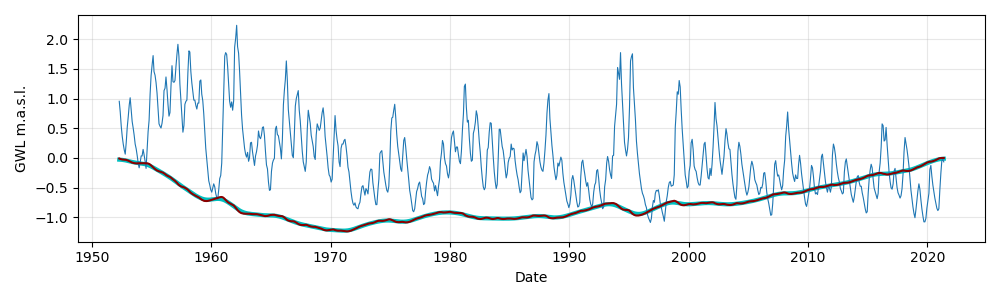

1.2374626506024067
yes
[0.55450554]


<IPython.core.display.Javascript object>


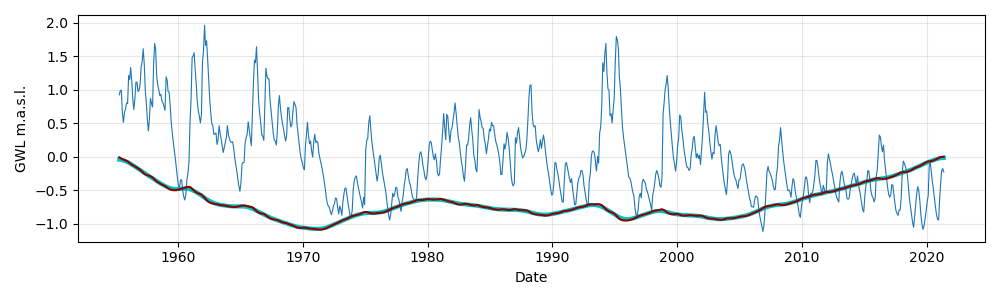

1.0896066750629685
yes
[0.53827003]


<IPython.core.display.Javascript object>


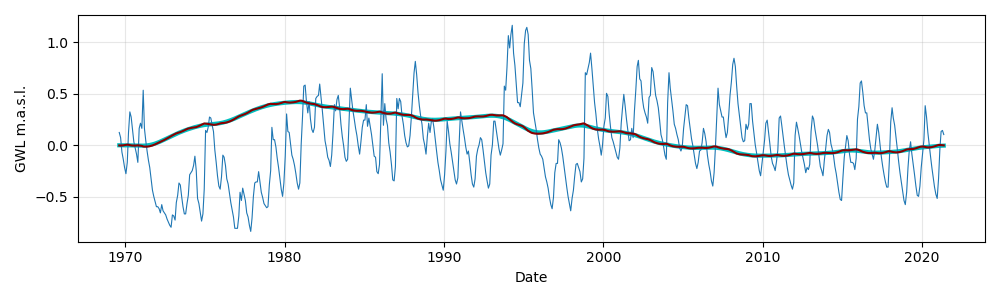

0.43363633440514676
yes
[0.37017542]


<IPython.core.display.Javascript object>


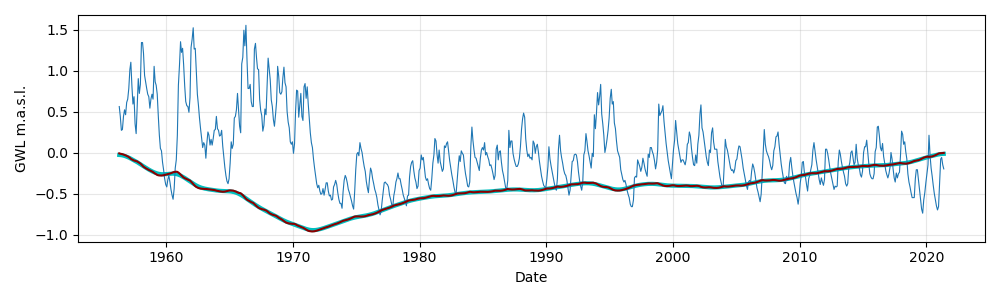

0.9570294117647024
yes
[0.51354093]


<IPython.core.display.Javascript object>


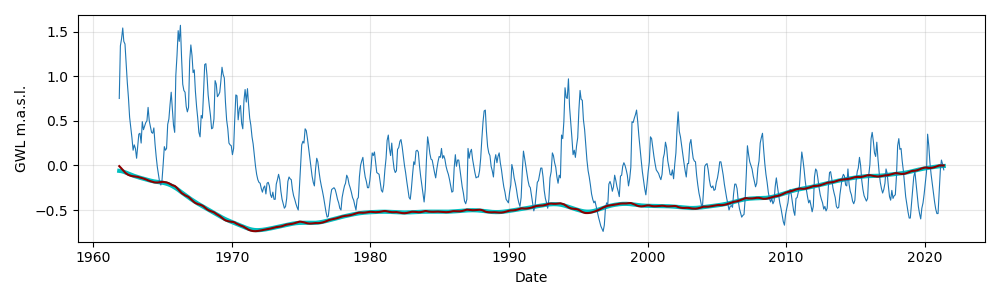

0.7369766433566477
yes
[0.58622121]


<IPython.core.display.Javascript object>


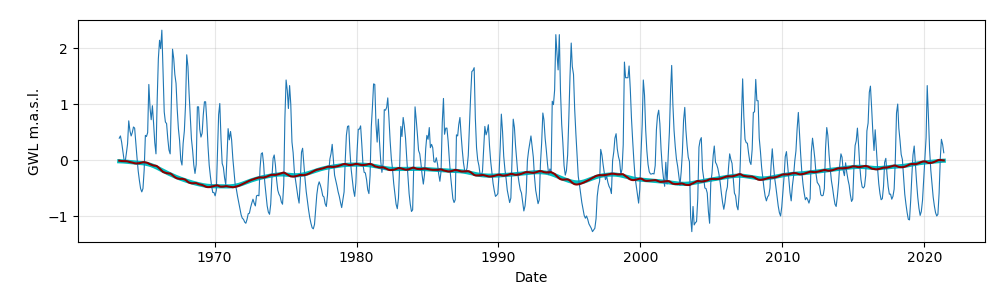

0.47929828080229014
yes
[0.59986497]


<IPython.core.display.Javascript object>


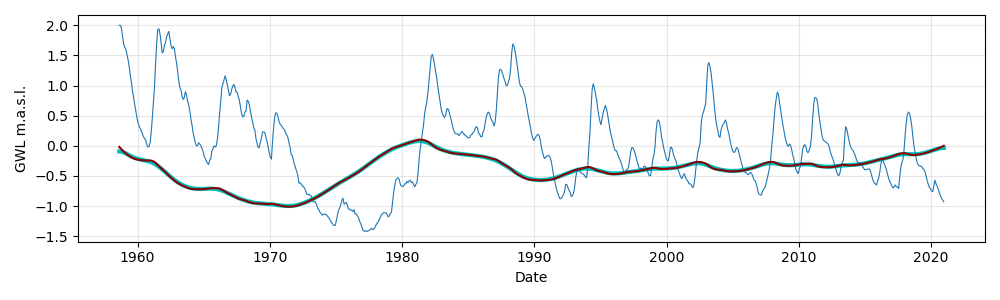

1.0106962616822437
yes
[0.60010153]


<IPython.core.display.Javascript object>


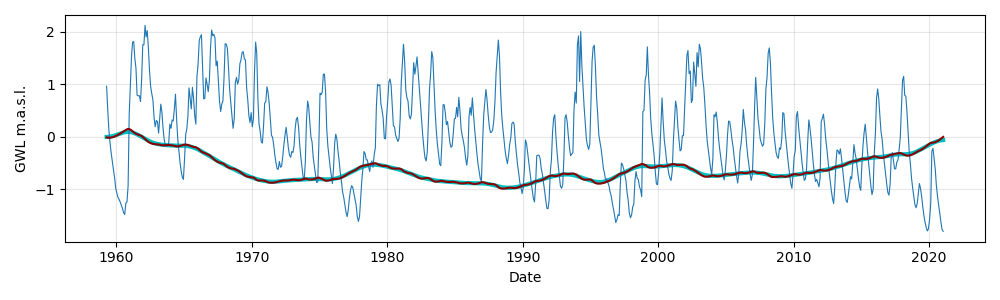

0.9836800539083381
yes
[0.25689111]


<IPython.core.display.Javascript object>


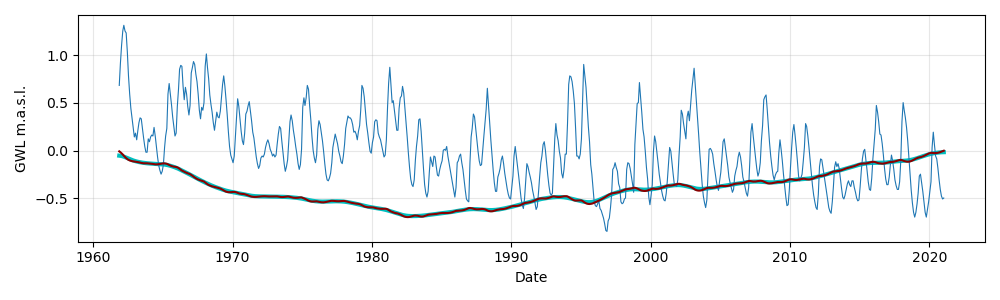

0.6958312236286938
yes
[0.2520928]


<IPython.core.display.Javascript object>


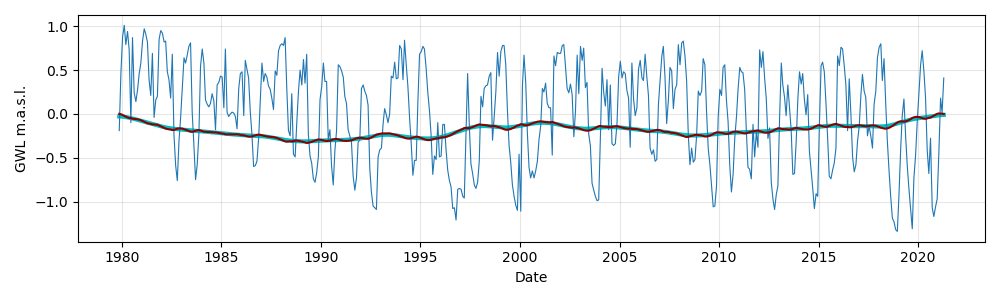

0.3304231137779079
yes
[0.27218953]


In [6]:

vwellid=[]
for datawell in vgwell:

    #select GWL data
    data=datawell[datawell.columns[-1]].values
    data-= np.mean(data) 
    
    #cumulative sum after the mean removal
    y= -1* np.cumsum(data)/100
    ycga=gaussian_filter1d(y,6)
    yg=gaussian_filter1d(data, 6)
    
    
    inddate=datawell.loc[datawell.DATUM== pd.to_datetime(datetime.date(1990, 1, 15))].index[0]
    mean1=np.mean(data[:-inddate])
    mean2=np.mean(data[-inddate:])
    meandif=abs(mean1-mean2)
    
    yl=np.abs(y)
    maxval=np.max(yl)
    indyl=np.where(yl==maxval)[0]
    inival=np.where(yl>=0.5*np.std(yl))[0][0]
    #print(inival)
    
    maxdate=datawell["DATUM"][indyl]
    yr=pd.to_datetime(datawell["DATUM"][indyl].values[0]).year
    
    #Slope before 1990 and initial point where the values increase by 0.5 of the standard deviation
    slope=(maxval-0.5*np.std(yl))/(indyl-inival)*100
    
    
    if slope[0] > 0.25 and yr<1990:
        vwellid.append(datawell.columns[-1][6:])

        #------------------------- Plot

        plt.figure(figsize=(10,3))
        plt.plot(datawell["DATUM"],ycga,'c', lw=3)

        plt.plot(datawell["DATUM"],data, lw=.8)
        plt.plot(datawell["DATUM"],y,'darkred')
        
        print(np.max(np.abs(y)))
        
        
        print("yes")

        print(slope)

        #plt.ylabel("GWL m.a.s.l.")
        #plt.xlabel("Date")
        #plt.grid(True, alpha=0.3)
        #plt.tight_layout()

## Modify and save the GWL time series

In [8]:
#save a "clean" list of wells where jumps were detected
vwellidint=[]
for v in vwellid:
    try:
        vwellidint.append(int(v))
    except:
        vwellidint.append(int(v[1:]))

#Select time series from 1990 onwards for time series with jumps        
for ind in GWfilldata.loc[GWfilldata.wellid.isin(vwellidint)].index:
    GWfilldata.GW_NN[ind]=GWfilldata.GW_NN[ind][GWfilldata.GW_NN[ind].DATUM>pd.to_datetime(datetime.date(1990, 1, 15))].reset_index(drop=True)
    

In [41]:
GWfilldata.to_pickle(rpath+"/Pickle/GWfilldatamod2.pkl")

In [45]:
#GWfilldatamod=pd.read_pickle(rpath+"/Pickle/GWfilldatamod2.pkl")
#GWfilldatamod1=pd.read_pickle(rpath+"/Pickle/GWfilldatamod.pkl")